In [64]:
import torch
import torchvision
from torchvision.models import vgg19, VGG19_Weights
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [47]:
device = torch.device("cuda:1")

## Define preprocess function 

In [48]:
imgsize = 256 # vgg input size
img_transforms = transforms.Compose([
    transforms.Resize((imgsize, imgsize)),
    transforms.ToTensor()
])

def image_loader(img_path):
    image = Image.open(img_path)
    image = img_transforms(image).unsqueeze(0)
    return image.to(device, torch.float)

def show_image(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)


In [49]:
content_img = image_loader("content_img.jpg")
style_img = image_loader("style_img.jpg")

content_img.shape, style_img.shape

(torch.Size([1, 3, 256, 256]), torch.Size([1, 3, 256, 256]))

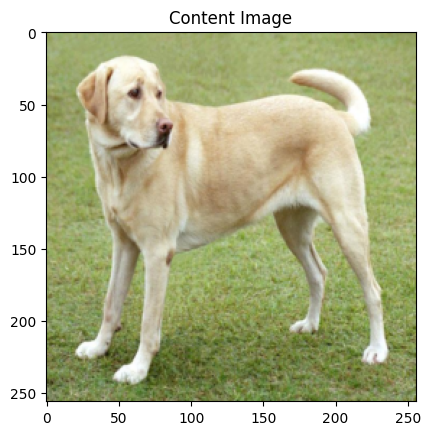

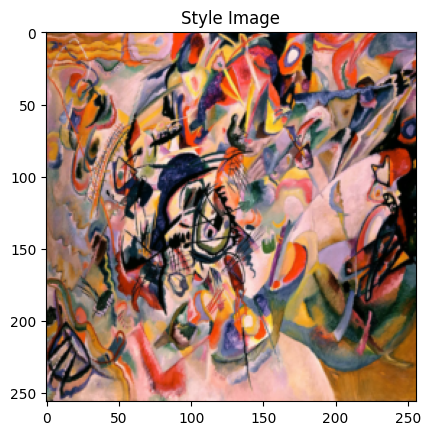

In [50]:
plt.figure()
show_image(content_img, title="Content Image")

plt.figure()
show_image(style_img, title="Style Image")

In [51]:
def get_features(model, image):
    # define vgg conv2d index layer
    layers = {
        '0': 'conv_1',
        '5': 'conv_2',
        '10': 'conv_3',
        '19': 'conv_4',
        '28': 'conv_5'
    }

    features = {}
    x = image
    # forward image and get features maps
    for name, pretrained_layer in model._modules.items():
        x = pretrained_layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

## Loss function

In [52]:
# content loss
content_weight = 1
ContentLoss = nn.MSELoss()

In [53]:
# Style Loss
def gram_matrix(tensor):
    a,b,c,d = tensor.size()
    tensor = tensor.view(a*b, c*d)
    G = torch.mm(tensor, tensor.t())
    return G.div(a*b*c*d)


style_weight = 1e6
StyleLoss = nn.MSELoss()

## Load VGG19 pretrained model

In [55]:
vgg19_model = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()
for param in vgg19_model.parameters():
    param.requires_grad_(False)
    
vgg19_model = vgg19_model.to(device)
vgg19_model

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:01<00:00, 292MB/s] 


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [57]:
content_features = get_features(vgg19_model, content_img)
style_features = get_features(vgg19_model, style_img)

In [58]:
for k, v in content_features.items():
    print(v.shape)

torch.Size([1, 64, 256, 256])
torch.Size([1, 128, 128, 128])
torch.Size([1, 256, 64, 64])
torch.Size([1, 512, 32, 32])
torch.Size([1, 512, 16, 16])


## Style tranfer process

In [59]:
import torch.optim as optim

In [61]:
# Initialize output image by copy from content image
output_img = content_img.clone().requires_grad_(True).to(device)
optimizer = optim.Adam([output_img], lr=0.02)

In [62]:
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [70]:
STEPS = 2000

for step in tqdm(range(STEPS), desc="Trasfering style"):
    optimizer.zero_grad()
    # get output feature by forward vgg19
    output_features = get_features(vgg19_model, output_img)
    # compute content loss from conv_1 feature map
    content_loss = ContentLoss(output_features['conv_1'], output_features['conv_1'])

    # compute style loss from all features map
    style_loss = 0
    for layer in style_layers:
        # compute gram matrix from feature map
        output_gram = gram_matrix(output_features[layer])
        style_gram = gram_matrix(style_features[layer])
        style_loss += StyleLoss(style_gram, output_gram)

    total_loss = content_loss*content_weight + style_loss*style_weight
    total_loss.backward()
    optimizer.step()

    with torch.no_grad():
        output_img.clamp_(0,1)

    if step % 100 == 0:
        print(f"Epoch [{step+1}/{STEPS}] total loss: {total_loss.item():.8f}")
        
        fname = 'results/at_%d.png' % (step+1)
        img = output_img[0].detach().cpu().permute(1, 2, 0).numpy()
        plt.imsave(fname, img)

Trasfering style:   1%|          | 21/2000 [00:00<00:19, 103.53it/s]

Epoch [1/2000] total loss: 0.20298976
(256, 256, 3)


Trasfering style:   6%|▌         | 115/2000 [00:01<00:19, 98.60it/s]

Epoch [101/2000] total loss: 0.19297622
(256, 256, 3)


Trasfering style:  11%|█         | 216/2000 [00:02<00:18, 97.03it/s] 

Epoch [201/2000] total loss: 0.18508652
(256, 256, 3)


Trasfering style:  15%|█▌        | 309/2000 [00:03<00:17, 98.87it/s] 

Epoch [301/2000] total loss: 0.18128012
(256, 256, 3)


Trasfering style:  21%|██        | 416/2000 [00:04<00:15, 104.35it/s]

Epoch [401/2000] total loss: 0.17680193
(256, 256, 3)


Trasfering style:  26%|██▌       | 516/2000 [00:04<00:13, 110.01it/s]

Epoch [501/2000] total loss: 0.17384413
(256, 256, 3)


Trasfering style:  31%|███       | 615/2000 [00:05<00:13, 106.15it/s]

Epoch [601/2000] total loss: 0.18890040
(256, 256, 3)


Trasfering style:  36%|███▌      | 712/2000 [00:06<00:13, 97.43it/s] 

Epoch [701/2000] total loss: 0.16665058
(256, 256, 3)


Trasfering style:  41%|████      | 824/2000 [00:07<00:10, 111.73it/s]

Epoch [801/2000] total loss: 0.16743970
(256, 256, 3)


Trasfering style:  46%|████▌     | 921/2000 [00:08<00:10, 102.57it/s]

Epoch [901/2000] total loss: 0.18448082
(256, 256, 3)


Trasfering style:  51%|█████     | 1013/2000 [00:09<00:10, 96.57it/s]

Epoch [1001/2000] total loss: 0.15664534
(256, 256, 3)


Trasfering style:  56%|█████▌    | 1120/2000 [00:10<00:09, 89.38it/s] 

Epoch [1101/2000] total loss: 1.71551776
(256, 256, 3)


Trasfering style:  61%|██████    | 1214/2000 [00:11<00:07, 101.77it/s]

Epoch [1201/2000] total loss: 0.21542311
(256, 256, 3)


Trasfering style:  66%|██████▌   | 1312/2000 [00:12<00:06, 102.07it/s]

Epoch [1301/2000] total loss: 0.18380596
(256, 256, 3)


Trasfering style:  71%|███████   | 1422/2000 [00:13<00:05, 104.70it/s]

Epoch [1401/2000] total loss: 0.17171432
(256, 256, 3)


Trasfering style:  76%|███████▌  | 1516/2000 [00:14<00:04, 99.94it/s] 

Epoch [1501/2000] total loss: 0.17527767
(256, 256, 3)


Trasfering style:  81%|████████  | 1612/2000 [00:15<00:04, 95.41it/s] 

Epoch [1601/2000] total loss: 0.17772442
(256, 256, 3)


Trasfering style:  86%|████████▌ | 1713/2000 [00:16<00:02, 110.93it/s]

Epoch [1701/2000] total loss: 0.16017662
(256, 256, 3)


Trasfering style:  91%|█████████ | 1815/2000 [00:17<00:01, 98.97it/s] 

Epoch [1801/2000] total loss: 0.15888155
(256, 256, 3)


Trasfering style:  96%|█████████▌| 1920/2000 [00:18<00:00, 101.77it/s]

Epoch [1901/2000] total loss: 0.17511547
(256, 256, 3)


Trasfering style: 100%|██████████| 2000/2000 [00:19<00:00, 105.18it/s]


### Output Image

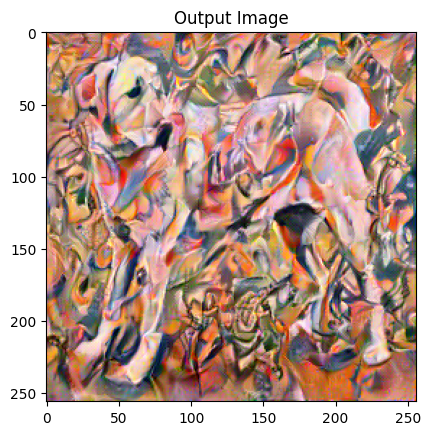

In [71]:
plt.figure()
show_image(output_img.detach(), title='Output Image')
plt.show()